# Wind Prediction v.s. Climo

In this example we are compare the wind power feed-ins calculated based `ECMWF-opendata` with the historical average caculated from `ERA5`, both by `atlite`.

In [1]:
from collections import OrderedDict

import pandas as pd
import pgeocode
import xarray as xr

import atlite

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")

### Germany wind installation

1.	打开 “扩展版单位总览（Erweiterte Einheitenübersicht）→ Stromerzeugungseinheiten（电力发电单元）”。页面支持筛选与 CSV 导出，且字段里有 Energieträger（能源/风）、Brutto-/Nettonennleistung（容量，kW）、Postleitzahl（PLZ）、Koordinate: Breitengrad/Längengrad (WGS84)（经纬度）等。 ￼
2.	在筛选栏设置（典型设置如下）：
	•	Energieträger = Wind（风能）
	•	Betriebs-Status = In Betrieb（在运），确保是存量在运装机

In [3]:
cols = OrderedDict(
    (
        ("installation_date", "Inbetriebnahmedatum der Einheit"),
        ("plz", "Postleitzahl"),
        ("city", "Ort"),
        ("type", "Energieträger"),
        ("capacity", "Nettonennleistung der Einheit"),
        ("level", "Spannungsebene"),
        ("lat", "Koordinate: Breitengrad (WGS84)"),
        ("lon", "Koordinate: Längengrad (WGS84)"),
        ("validation", "Netzbetreiberprüfung"),
    )
)

database = pd.concat(
    [
        pd.read_csv(
            filename,
            sep=";",
            decimal=",",
            usecols=list(cols.values()),
        )
        for filename in [
            "Stromerzeuger_1_bis_25000 1_bis_25000 .csv",
            "Stromerzeuger_25001_bis_31683 25001_bis_31683 .csv",
        ]
    ]
).rename(columns={v: k for k, v in cols.items()})
# Keep only valid + with PLZ
database = database[
    (database["plz"].notna()) & (database["validation"] == "Geprüft")
]
# German postal codes must be strings
database["plz"] = database["plz"].astype(int).astype(str)
# Parse dates
database["installation_date"] = pd.to_datetime(
    database["installation_date"], errors="coerce"
)
# Fill missing coordinates from postal codes
de_nomi = pgeocode.Nominatim("de")
plz_coords = de_nomi.query_postal_code(database["plz"].values)
database = pd.merge(
    database,
    plz_coords[["postal_code", "latitude", "longitude"]],
    left_on="plz",
    right_on="postal_code",
    how="left",
)
database["lat"] = database["lat"].fillna(database["latitude"])
database["lon"] = database["lon"].fillna(database["longitude"])
database = database.drop(labels=["postal_code", "latitude", "longitude"], axis="columns").dropna(subset=["lat", "lon"])
database["capacity"] /= 1e3 # kW -> MW
database = database.rename(columns={"lon": "x", "lat": "y"})
database

,type,capacity,installation_date,plz,city,y,x,validation,level
0,Wind,3.0000,2017-09-01,34298,Helsa,51.270068,9.739374,Geprüft,Hochspannung
1,Wind,3.0000,2017-09-01,34298,Helsa,51.270068,9.739374,Geprüft,Hochspannung
2,Wind,3.0000,2017-09-01,34298,Helsa,51.270068,9.739374,Geprüft,Hochspannung
3,Wind,3.0000,2017-09-01,34298,Helsa,51.270068,9.739374,Geprüft,Hochspannung
4,Wind,3.0000,2017-09-01,34298,Helsa,51.270068,9.739374,Geprüft,Hochspannung
...,...,...,...,...,...,...,...,...,...
1094419,Wind,0.0300,2024-07-18,48727,Billerbeck,51.978300,7.292600,Geprüft,Mittelspannung
1094420,Wind,0.0300,2024-07-18,48727,Billerbeck,51.978300,7.292600,Geprüft,Mittelspannung
1094421,Wind,0.0010,2025-07-10,58300,Wetter,51.387500,7.392800,Geprüft,Niederspannung (= Hausanschluss/Haushaltsstrom)
1094422,Wind,0.0010,2025-07-10,58300,Wetter,51.387500,7.392800,Geprüft,Niederspannung (= Hausanschluss/Haushaltsstrom)


## Prediction for Germany

In [4]:
init_time = pd.Timestamp.today().normalize() - pd.Timedelta(days=1)
cycle = 0
lead_time = pd.Timedelta(days=10)
valid_time = init_time + lead_time
print(f"Init time: {init_time}, lead time: {lead_time}, valid time: {valid_time.date()}")

Init time: 2025-09-30 00:00:00, lead time: 10 days 00:00:00, valid time: 2025-10-10


### Create a Cutout from IFS ENS

Load the country shape for Germany and determine its geographic bounds for downloading the appropriate cutout from ECMWF's ERA5 and Open data set.

In [5]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd

shp = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
)
de_record = list(filter(lambda c: c.attributes["ISO_A2"] == "DE", shp.records()))[0]
de = pd.Series({**de_record.attributes, "geometry": de_record.geometry})
x1, y1, x2, y2 = de["geometry"].bounds

In [6]:
cutout = atlite.Cutout(
    path="germany-prediction.nc",
    module=["ifs_ens"],
    x=slice(x1 - 0.2, x2 + 0.2),
    y=slice(y1 - 0.2, y2 + 0.2),
    chunks={"time": 100},
    time=valid_time.strftime("%Y-%m-%d"),
    init_time=init_time.strftime("%Y-%m-%d"),
    cycle=cycle,
)

/workspaces/atlite-meets-earthkit-data/atlite/cutout.py:157: UserWarning: Arguments module, x, y, time, init_time, cycle are ignored, since cutout is already built.
  warn(


In [7]:
cutout.prepare()

<Cutout "germany-prediction">
 x = 5.75 ⟷ 15.00, dx = 0.25
 y = 47.25 ⟷ 55.25, dy = 0.25
 time = 2025-10-10 ⟷ 2025-10-10, dt = h
 module = ifs_ens
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

*Downloading the cutout can take a few seconds or even an hour, depending on your internet connection and whether the dataset
was recently requested from the data set provider (and is thus cached on their premise).
For us this took ~2 minutes the first time. Preparing it again (a second time) is snappy (for whatever reason you would want to download the same cutout twice).*

In [8]:
interpolated_data = cutout.data.mean(dim="number", skipna=True).interpolate_na(dim="time", method="linear")
interpolated_data.attrs = cutout.data.attrs
cutout.data = interpolated_data

### Convert cutout into wind power

These wind turbines are available in atlite.

In [9]:
for t in atlite.windturbines:
    print(f"* {t}")

* NREL_ReferenceTurbine_2020ATB_5.5MW
* Vestas_V47_660kW
* NREL_ReferenceTurbine_2019ORCost_15MW_offshore
* Vestas_V112_3MW_offshore
* NREL_ReferenceTurbine_2020ATB_4MW
* Suzlon_S82_1.5_MW
* Vestas_V164_7MW_offshore
* NREL_ReferenceTurbine_2016CACost_6MW_offshore
* NREL_ReferenceTurbine_2020ATB_18MW_offshore
* NREL_ReferenceTurbine_2016CACost_8MW_offshore
* NREL_ReferenceTurbine_2016CACost_10MW_offshore
* NREL_ReferenceTurbine_2020ATB_12MW_offshore
* Enercon_E126_7500kW
* Bonus_B1000_1000kW
* Vestas_V90_3MW
* NREL_ReferenceTurbine_2019ORCost_12MW_offshore
* NREL_ReferenceTurbine_5MW_offshore
* NREL_ReferenceTurbine_2020ATB_7MW
* Vestas_V80_2MW_gridstreamer
* Enercon_E101_3000kW
* Vestas_V25_200kW
* Vestas_V112_3MW
* Enercon_E82_3000kW
* Siemens_SWT_107_3600kW
* Siemens_SWT_2300kW
* NREL_ReferenceTurbine_2020ATB_15MW_offshore
* Vestas_V66_1750kW


Here we create a layout for capacity <400kW as an example

In [10]:
turbine = "Vestas_V25_200kW"
capacities = database[
    (database["type"] == "Wind") & (database["capacity"] <= 0.4)
]
layout = cutout.layout_from_capacity_list(capacities, "capacity")

In [11]:
generation = cutout.wind(
    turbine=turbine,
    add_cutout_windspeed=True,
    interpolation_method="power",
    layout=layout,
    show_progress=False,
)
generation

<xarray.DataArray 'specific generation' (time: 24, dim_0: 1)> Size: 192B
array([[ 893.49674519],
       [ 903.05431476],
       [ 912.65999483],
       [ 922.29566679],
       [ 931.92773327],
       [ 941.57768385],
       [ 951.33178017],
       [ 981.6678366 ],
       [1014.49871055],
       [1049.3944064 ],
       [1086.58796546],
       [1126.53016274],
       [1170.3724139 ],
       [1071.49868088],
       [ 980.68442897],
       [ 896.98892539],
       [ 820.24901242],
       [ 749.14315712],
       [ 682.56441296],
       [          nan],
       [          nan],
       [          nan],
       [          nan],
       [          nan]])
Coordinates:
  * time     (time) datetime64[ns] 192B 2025-10-10 ... 2025-10-10T23:00:00
  * dim_0    (dim_0) int64 8B 0
Attributes:
    units:    MW

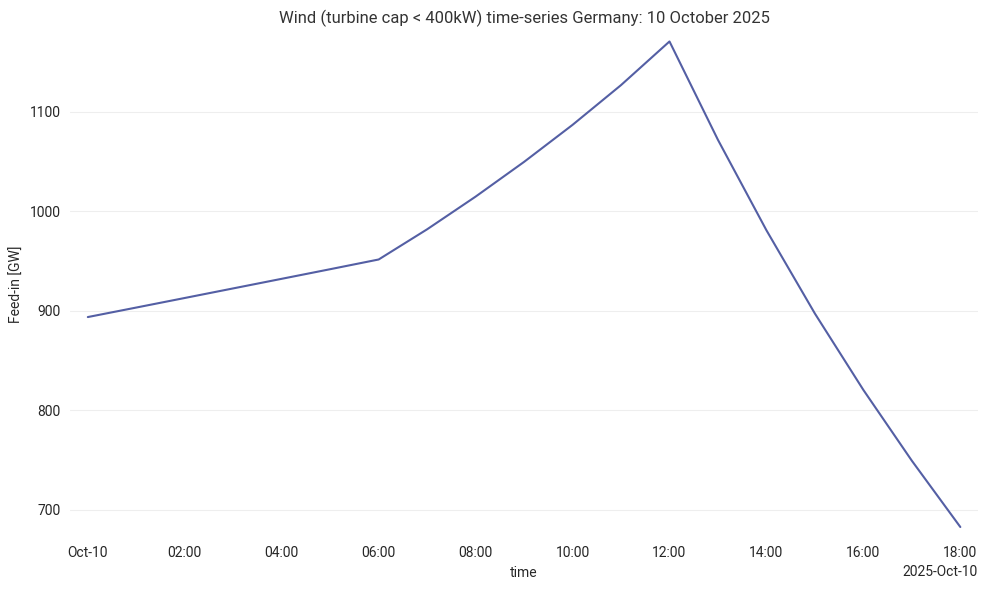

In [12]:
generation.isel(dim_0=0).plot(figsize=(10, 6))
date = pd.to_datetime(cutout.coords["time"].values[0])
plt.ylabel("Feed-in [GW]")
plt.title(f"Wind (turbine cap < 400kW) time-series Germany: {date.strftime('%d %B %Y')}")
plt.tight_layout()

## Splitting time-series into shapes

The generation time-series can also be aggregated based on shapes.
In this example, we aggregate on the basis of the German "Länder" (federal states).

In [13]:
shp = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_1_states_provinces"
    )
)
de_records = list(
    filter(lambda r: r.attributes["iso_3166_2"].startswith("DE"), shp.records())
)
laender = (
    gpd.GeoDataFrame([{**r.attributes, "geometry": r.geometry} for r in de_records])
    .rename(columns={"iso_3166_2": "state"})
    .set_index("state")
    .set_crs(4236)
)

(np.float64(4017474.5291667674),
 np.float64(4684246.302388124),
 np.float64(2666822.8681802526),
 np.float64(3569582.041424758))

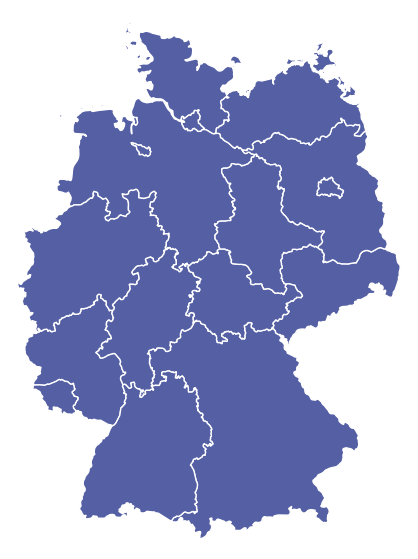

In [14]:
laender.to_crs(3035).plot(figsize=(7, 7))
plt.grid(False)
plt.axis("off")

In [15]:
import numpy as np
# datamodules[].crs
cutout.data.attrs

{'module': 'ifs_ens',
 'prepared_features': ['wind', 'height', 'runoff', 'temperature', 'influx'],
 'chunksize_time': 100,
 'init_time': '2025-09-30',
 'cycle': np.int64(0),
 'GRIB_centre': 'ecmf',
 'GRIB_centreDescription': 'European Centre for Medium-Range Weather Forecasts',
 'GRIB_subCentre': np.int64(0),
 'Conventions': 'CF-1.7',
 'institution': 'European Centre for Medium-Range Weather Forecasts',
 'history': '2025-10-01T00:14 GRIB to CDM+CF via cfgrib-0.9.15.0/ecCodes-2.43.0 with {"source": "../../../tmp/tmpjsl3cd95/tmp33sl0dzw.grib2", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}'}

In [16]:
generation = cutout.wind(
    turbine=turbine,
    add_cutout_windspeed=True,
    interpolation_method="power",
    shapes=laender,
    layout=layout,
)

(np.float64(5.669098478020107),
 np.float64(15.205450756980053),
 np.float64(47.11523664168007),
 np.float64(55.221218646320054))

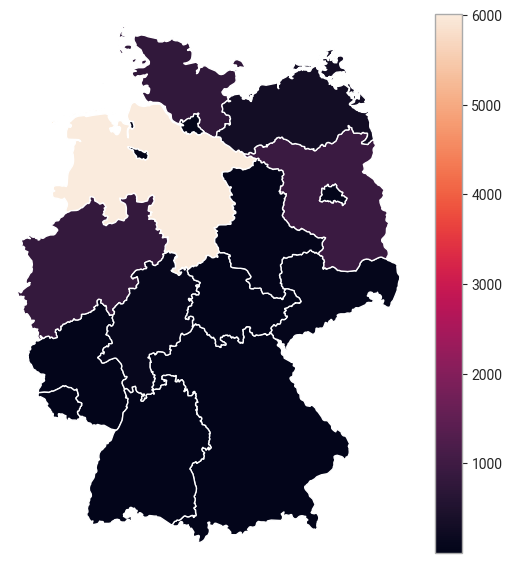

In [17]:
production = generation.sum("time").to_series()
laender.plot(column=production, figsize=(7, 7), legend=True)
plt.grid(False)
plt.axis("off")

<Axes: xlabel='state'>

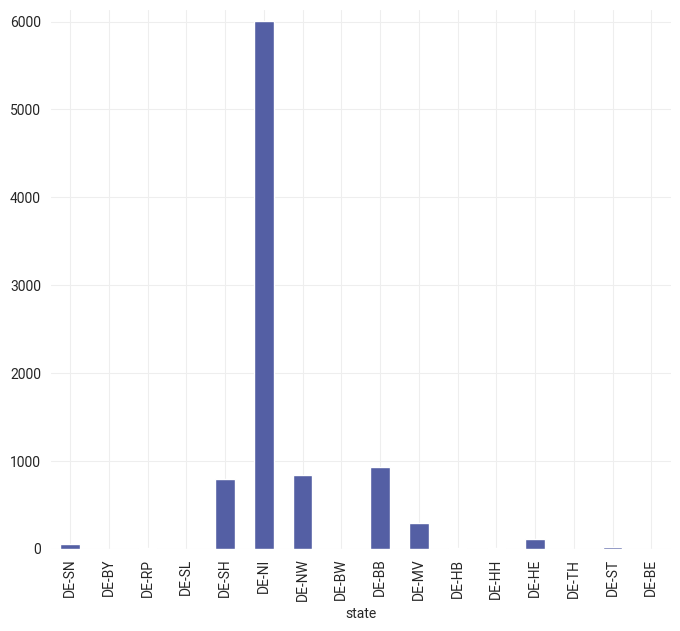

In [18]:
production.plot(kind="bar")